In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import uniform, gumbel_r
from scipy.optimize import fsolve
import seaborn as sns
import os

plt.style.use('seaborn')

atlantic = np.genfromtxt('atlantic.txt')


# Methods for exporting tables and images to latex
def saveimg(filename, fig):
    file_path = os.path.join(os.getcwd(), 'images')
    os.makedirs(file_path, exist_ok=True)
    fig.savefig(os.path.join(file_path, filename))
    
def savetable(filename, df):
    file_path = os.path.join(os.getcwd(), 'tables')
    os.makedirs(file_path, exist_ok=True)
    pd.DataFrame(df).to_latex(os.path.join(file_path, filename),escape = False, index = False)

In [101]:
def wgumbafit(a,data):
    return a-np.mean(data)+np.mean(data*np.exp(-data/a))/np.mean(np.exp(-data/a))

def est_gumbel(data):
    start = 6**(1/2)/np.pi*np.std(data)
    beta = fsolve(wgumbafit, start, args = (data))[0]
    mu = -beta*np.log(np.mean(np.exp(-data/beta)))
    return beta, mu

def gumbel_inv(u_samples, beta, mu):
    return mu-beta*np.log(-np.log(u_samples))

In [231]:
beta, mu = est_gumbel(atlantic)

n = len(atlantic)
B = 10**5
u = np.random.uniform(size = (n,B))

boot = gumbel_inv(u, beta, mu)

parameters_boot = np.apply_along_axis(est_gumbel, 0, boot)
    
lower = np.quantile(parameters_boot, 0.025,  axis = 1)
upper = np.quantile(parameters_boot, 0.975, axis = 1)

interval_beta = np.array([lower[0], upper[0]])
interval_mu = np.array([lower[1], upper[1]])

print(f'Interval Beta {interval_beta}')
print(f'Interval Mu {interval_mu}')

T = 14*3*100
u_max = 1-1/T
max_wave = np.zeros(B)

for index in range(B):
    max_wave[index] = gumbel_inv(u_max, parameters_boot[0, index], parameters_boot[1, index])
    
upper_wave = np.quantile(max_wave, 0.95)

print(f'Largest Wave: {upper_wave}')

Interval Beta [1.39033364 1.57919068]
Interval Mu [4.02155856 4.27653603]
Largest Wave: 17.235329022444642


In [263]:
estimates = [{'Parameter': r'$\beta$', 'Estimate': beta, '95\% Upper bound': interval_beta[1], '95\% Lower bound': interval_beta[0]}, 
            {'Parameter': '$\mu$', 'Estimate': mu, '95\% Upper bound': interval_mu[1], '95\% Lower bound': interval_mu[0]}]
df_estimates = pd.DataFrame.from_dict(estimates)
savetable('parameters.tex', df_estimates)
wave = [{'Parameter': "100-year wave", 'Mean' : np.mean(max_wave), "95\% Upper bound" : upper_wave}]
df_wave = pd.DataFrame.from_dict(wave)
savetable('bigwave.tex', df_wave)

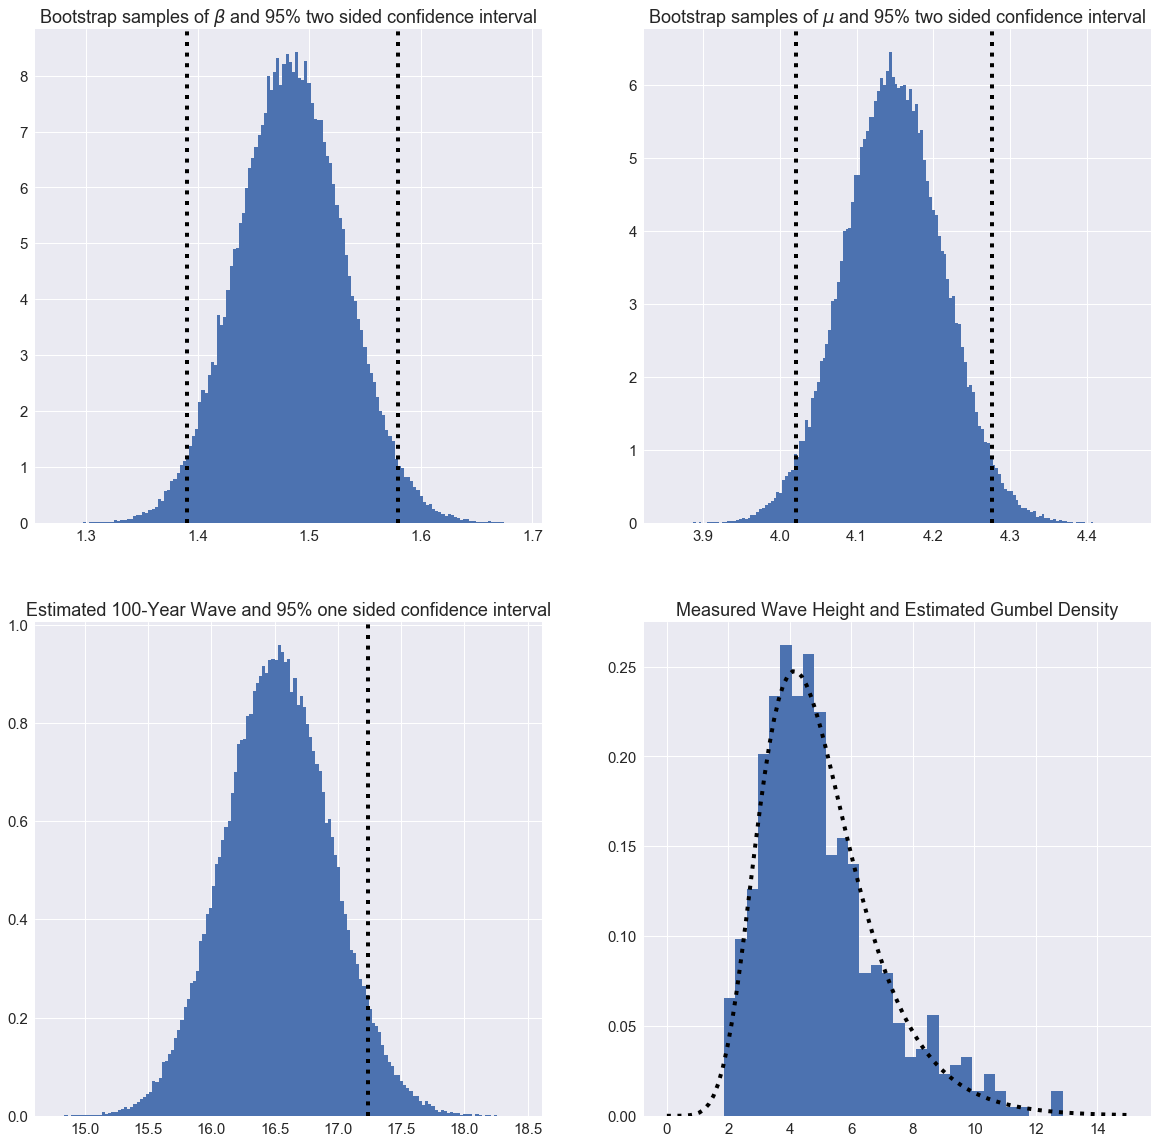

NameError: name 'results_bootstrap' is not defined

In [260]:
fig, axes = plt.subplots(2,2, figsize = (20,20))


axes[0,0].hist(parameters_boot[0], bins = 'auto', density = True)
axes[0,0].set_title(r'Bootstrap samples of $\beta$ and 95% two sided confidence interval', size = 18)
axes[0,0].axvline(interval_beta[0], color = 'k', linestyle='dotted', linewidth = 4)
axes[0,0].axvline(interval_beta[1], color = 'k', linestyle='dotted', linewidth = 4)
axes[0,0].tick_params(axis='x', labelsize= 15)
axes[0,0].tick_params(axis='y', labelsize= 15)


axes[0,1].hist(parameters_boot[1], bins = 'auto', density = True)
axes[0,1].set_title('Bootstrap samples of $\mu$ and 95% two sided confidence interval', size = 18)
axes[0,1].axvline(interval_mu[0], color = 'k', linestyle='dotted', linewidth = 4)
axes[0,1].axvline(interval_mu[1], color = 'k', linestyle='dotted', linewidth = 4)
axes[0,1].tick_params(axis='x', labelsize= 15)
axes[0,1].tick_params(axis='y', labelsize= 15)

axes[1,0].hist(max_wave, bins = 'auto', density = True)
axes[1,0].set_title('Estimated 100-Year Wave and 95% one sided confidence interval', size = 18)
axes[1,0].axvline(upper_wave, color = 'k', linestyle='dotted', linewidth = 4)
axes[1,0].tick_params(axis='x', labelsize= 15)
axes[1,0].tick_params(axis='y', labelsize= 15)

axes[1,1].hist(atlantic, bins = 30, density = True)
axes[1,1].set_title('Measured Wave Height and Estimated Gumbel Density', size = 18)
x = np.linspace(0,15, 100)
axes[1,1].plot(x, gumbel_r.pdf(x, loc = mu, scale = beta), linewidth = 4, color = 'k', linestyle='dotted')
axes[1,1].tick_params(axis='x', labelsize= 15)
axes[1,1].tick_params(axis='y', labelsize= 15)

plt.show()

saveimg(results_bootstrap.png, fig)